In [1]:
import datetime
import ee
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import os

ee.Initialize()

# Define init params - area, satellite, years

In [2]:
def init():
    
    '''
    Set the init params:
    1) Area
    2) Satellite 
    3) Years to analyze 
    
    '''
    
    ##### AREA #####
    

    # County 
    area = (ee.FeatureCollection('ft:1FEPBzXYqUbdWXG2wTFOyb-ts9_GbeI5NFraMq2yk').filter(ee.Filter().eq('COUNTY num', 95)))
    
    # Central Valley
    area = ee.FeatureCollection('ft:1h46ENpEp8vO3pOe1EqeF1sZLEDhSVMxbu8pHAoU4', 'geometry')
        
    # Whole state:
    area = (ee.FeatureCollection('ft:1fRY18cjsHzDgGiJiS2nnpUU3v9JPDc2HNaR7Xk8').filter(ee.Filter().eq('Name', 'California')))
    
    # CV watersheds
    # TODO 
    
    ###### SATELLITES ######
    
    trmm = ee.ImageCollection('TRMM/3B42')
    prism = ee.ImageCollection("OREGONSTATE/PRISM/AN81m")
    chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD')
    
    ##### TIME RANGE #####
    years = [x for x in range(2000, 2016)]
    
    return [[trmm,prism,chirps],area,years]
    

def retrieve(satellite):
    if satellite == ee.ImageCollection('TRMM/3B42'):
        var = "precipitation"
    if satellite == ee.ImageCollection("OREGONSTATE/PRISM/AN81m"):
        var = "ppt"
    if satellite == ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD'):
        var = "precipitation"
    return var

### Helpers 

In [3]:
def filter_date(product,year):
    startyear = ee.Date.fromYMD(year,1,1)
    endyear =ee.Date.fromYMD(year+1,12,31)
    prod = product.filterDate(startyear, endyear).sort('system:time_start', False).select(retrieve(product))
    return prod
    
def aggregate_precip(product,year):
    
    # Select appropriate resolution from product. Set lower if you exceed the google request
    if product == ee.ImageCollection('TRMM/3B42'):
        res = 12500
    elif product == ee.ImageCollection("OREGONSTATE/PRISM/AN81m"):
        res = 3200
    elif product == ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD'):
        res = 5500
    
    # Filter
    filtered = filter_date(product, year)

    # calculate the monthly mean
    def calcMean(imageCollection,year):
        mylist = ee.List([])
        months = range(1,13)
        for m in months:
                w = imageCollection.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).sum();
                mylist = mylist.add(w.set('year', year).set('month', m).set('date', ee.Date.fromYMD(year,m,1)).set('system:time_start',ee.Date.fromYMD(year,m,1)))
        return ee.ImageCollection.fromImages(mylist)

    # run the calcMonthlyMean function
    monthly = ee.ImageCollection(calcMean(filtered, year))

    # select the region of interest, res is the cellsize in meters
    monthly = monthly.getRegion(area,res,"epsg:4326").getInfo()

    return monthly 

def df_from_ee_object(imcol):
    df = pd.DataFrame(imcol, columns = imcol[0])
    df = df[1:]
    return(df)

def array_from_df(df, variable, month):
    df = df[df.id == str(month)] 
    
    # get data from df as arrays
    lons = np.array(df.longitude)
    lats = np.array(df.latitude)
    data = np.array(df[variable]) # Set var here 
                                              
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)

    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)    
    nrows = len(uniqueLats)

    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0] 
    xs = uniqueLons[1] - uniqueLons[0]

    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32)

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
    
    return arr

# Main

In [4]:
def main(years, product, timeseries = False):
    finals = []
    for year in years:
        finals.append(aggregate_precip(product,year))
    
    dfs = []
    for i in finals:
        dfs.append(df_from_ee_object(i))
    
    months = [int(x) for x in dfs[0].id.unique()]
    
    yearly = []
    for i in dfs:
        result = []
        for m in months:
            monthly = []
            a = array_from_df(i,retrieve(product),m)
            result.append(a)
        yearly.append(result)
        
    yearly_arrays = [np.array(x) for x in yearly]
    timeseries = [np.array(x) for x in yearly_arrays]
    all_data = [item for sublist in timeseries for item in sublist]
    final = np.dstack(all_data)
    final = np.ma.masked_where(final == 0, final)
    dist = final[np.logical_not(np.isnan(final))]
    
    return final

In [5]:
sats, area, years = init()

In [6]:
trmm = main(years, sats[0])
pris = main(years, sats[1])
chrps = main(years, sats[2])

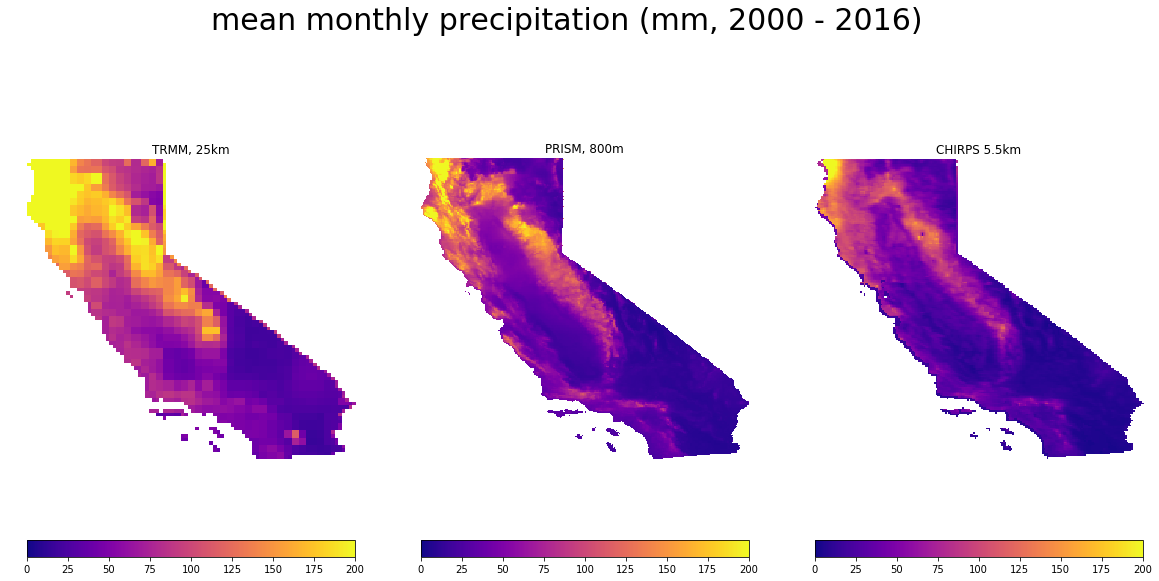

In [7]:
normalized_cmap = matplotlib.colors.Normalize(vmin=0, vmax=200)

f = plt.figure(figsize=(20,10))

plt.suptitle("mean monthly precipitation (mm, 2000 - 2016)", size = 30)

plt.subplot(1,3,1)
plt.imshow(np.mean(trmm, axis = 2)*8,cmap = plt.get_cmap("plasma"), norm=normalized_cmap)
plt.colorbar(orientation='horizontal')
plt.title("TRMM, 25km")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(np.mean(pris, axis = 2),cmap = plt.get_cmap("plasma"), norm=normalized_cmap)
plt.title("PRISM, 800m")
plt.colorbar(orientation='horizontal')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(np.mean(chrps, axis = 2),cmap = plt.get_cmap("plasma"), norm=normalized_cmap)
plt.title("CHIRPS 5.5km")
plt.colorbar(orientation='horizontal')
plt.axis('off')

plt.savefig("mean_monthly_precip.png")

plt.show()

In [8]:
# regress trendlines over time

from scipy import stats

In [9]:
def calc_spatial_trend(array):

    t = array.copy()

    x_array = np.arange(t.shape[2]) # time dimension

    slopes = []

    for i in range(0, t.shape[0]):
        for j in range(0, t.shape[1]):
                y_array = t[i,j,:]
                slope, intercept, r_value, p_value, std_err = stats.linregress(x_array,y_array)
                slopes.append(slope)
                
    s = np.array(slopes)
    s = s.reshape(t.shape[0],t.shape[1])
    s[s == 0 ] = np.nan
    
    return s

In [10]:
tst = calc_spatial_trend(trmm)
pst = calc_spatial_trend(pris)
cst = calc_spatial_trend(chrps)

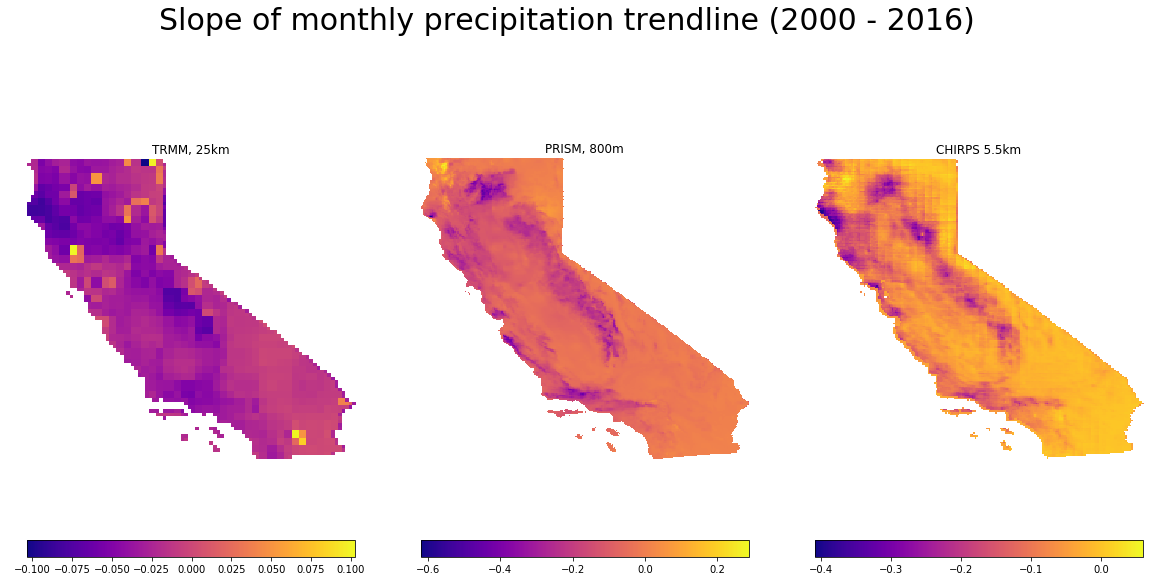

In [11]:
f = plt.figure(figsize=(20,10))

plt.suptitle("Slope of monthly precipitation trendline (2000 - 2016)", size = 30)

plt.subplot(1,3,1)
plt.imshow(tst,cmap = plt.get_cmap("plasma"))
plt.colorbar(orientation='horizontal')
plt.title("TRMM, 25km")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(pst,cmap = plt.get_cmap("plasma"))
plt.title("PRISM, 800m")
plt.colorbar(orientation='horizontal')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(cst,cmap = plt.get_cmap("plasma"))
plt.title("CHIRPS 5.5km")
plt.colorbar(orientation='horizontal')
plt.axis('off')

plt.show()

In [12]:
# P value and R values

In [13]:
def get_spatial_stats(array):

    t = array.copy()

    x_array = np.arange(t.shape[2]) # time dimension

    ps = []
    rs = []

    for i in range(0, t.shape[0]):
        for j in range(0, t.shape[1]):
                y_array = t[i,j,:]
                slope, intercept, r_value, p_value, std_err = stats.linregress(x_array,y_array)
                ps.append(p_value)
                rs.append(r_value)
          
    p = np.array(ps)
    p = p.reshape(t.shape[0],t.shape[1])
    p[p == 0 ] = np.nan
    p[p == 1 ] = np.nan

    r = np.array(rs)
    r = r.reshape(t.shape[0],t.shape[1])
    r[r == 0 ] = np.nan
    
    return p,r

In [14]:
tp, tr = get_spatial_stats(trmm)
pp, pr = get_spatial_stats(pris)
cp, cr = get_spatial_stats(chrps)

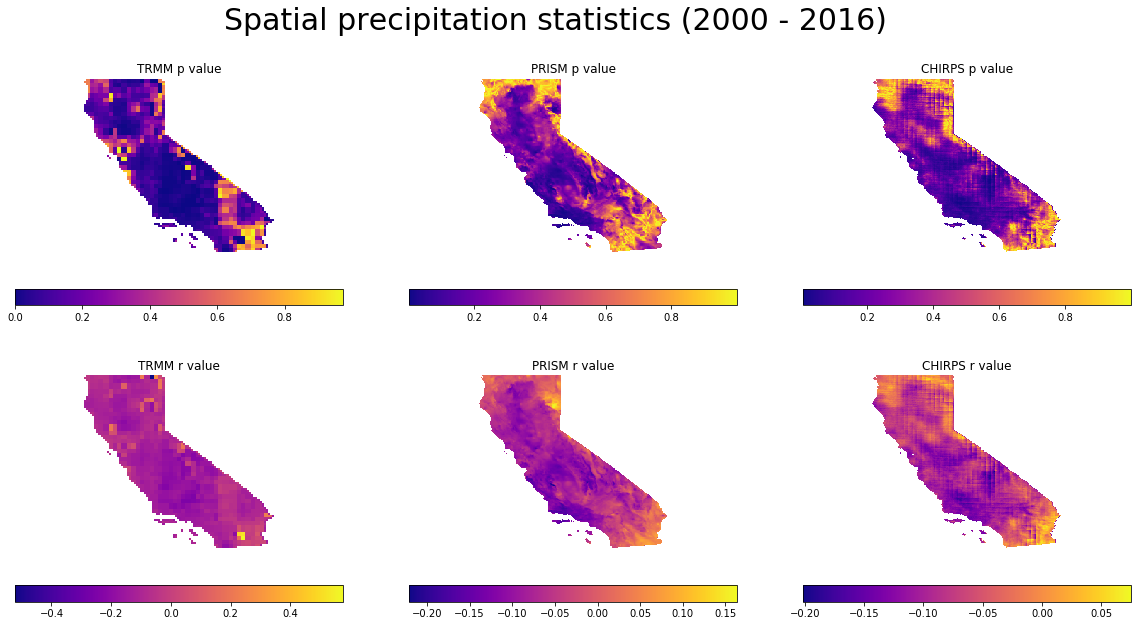

In [15]:
f = plt.figure(figsize=(20,10))

plt.suptitle("Spatial precipitation statistics (2000 - 2016)", size = 30)

plt.subplot(2,3,1)
plt.imshow(tp,cmap = plt.get_cmap("plasma"))
plt.colorbar(orientation='horizontal')
plt.title("TRMM p value")
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(pp,cmap = plt.get_cmap("plasma"))
plt.title("PRISM p value")
plt.colorbar(orientation='horizontal')
plt.axis('off')

plt.subplot(2,3,3)
plt.imshow(cp,cmap = plt.get_cmap("plasma"))
plt.title("CHIRPS p value")
plt.colorbar(orientation='horizontal')
plt.axis('off')

plt.subplot(2,3,4)
plt.imshow(tr,cmap = plt.get_cmap("plasma"))
plt.title("TRMM r value")
plt.colorbar(orientation='horizontal')
plt.axis('off')

plt.subplot(2,3,5)
plt.imshow(pr,cmap = plt.get_cmap("plasma"))
plt.title("PRISM r value")
plt.colorbar(orientation='horizontal')
plt.axis('off')

plt.subplot(2,3,6)
plt.imshow(cr,cmap = plt.get_cmap("plasma"))
plt.title("CHIRPS r value")
plt.colorbar(orientation='horizontal')
plt.axis('off')

plt.savefig("stats.png")
plt.show()

In [16]:
def get_monthly_sum(array):
    arr = array.copy()
    
    totals = []
    for i in range(0,array.shape[2]):
        total = np.nanmean(array[:,:,i]) * array.shape[0] *array.shape[2]
        totals.append(total)
        
    return np.array(totals)

In [17]:
t_sums = get_monthly_sum(trmm)*8. # 3 hourly data 
p_sums = get_monthly_sum(pris)
c_sums = get_monthly_sum(chrps)

In [18]:
from dateutil.relativedelta import relativedelta

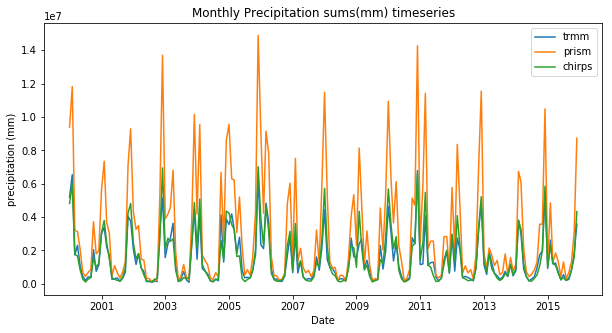

In [19]:
dates = [datetime.date(2000, 1, 1) + relativedelta(months=x) for x in range(0, 192)]

plt.figure(figsize=(10,5))
plt.title("Monthly Precipitation sums(mm) timeseries")
plt.plot(dates,t_sums, label = "trmm")
plt.plot(dates,p_sums, label = "prism")
plt.plot(dates,c_sums, label = "chirps")
plt.ylabel("precipitation (mm)")
plt.xlabel("Date")
plt.legend()
plt.show()

In [20]:
t_slope, t_intercept, t_r_value, t_p_value, t_std_err = stats.linregress(np.arange(0,len(dates)),t_sums)
p_slope, p_intercept, p_r_value, p_p_value, p_std_err = stats.linregress(np.arange(0,len(dates)),p_sums)
c_slope, c_intercept, c_r_value, c_p_value, c_std_err = stats.linregress(np.arange(0,len(dates)),c_sums)

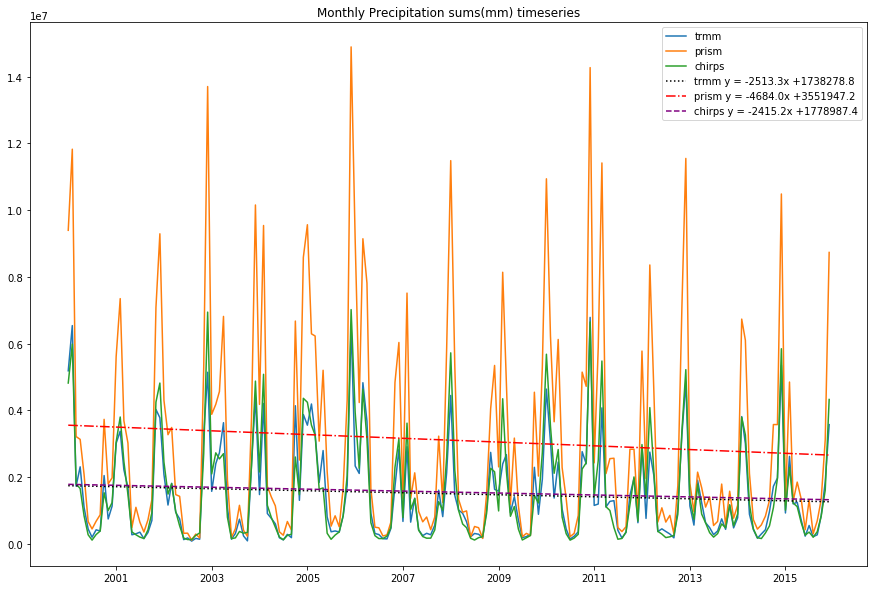

In [21]:
plt.figure(figsize=(15,10))

plt.title("Monthly Precipitation sums(mm) timeseries")
plt.plot(dates,t_sums, label = "trmm")
plt.plot(dates,p_sums, label = "prism")
plt.plot(dates,c_sums, label = "chirps")

plt.plot(dates, t_intercept + t_slope*np.arange(0,len(dates)), 'black', linestyle = ":",  label='trmm y = {}x +{}'.format(round(t_slope,1), round(t_intercept,1)))
plt.plot(dates, p_intercept + p_slope*np.arange(0,len(dates)), 'red', linestyle = "-.", label='prism y = {}x +{}'.format(round(p_slope,1), round(p_intercept,1)))
plt.plot(dates, c_intercept + c_slope*np.arange(0,len(dates)), 'purple', linestyle = "--", label='chirps y = {}x +{}'.format(round(c_slope,1), round(c_intercept,1)))

plt.legend()
         

In [22]:
# Write sums to file

In [23]:
outdf = pd.DataFrame(
    {'trmm': t_sums,
     'prism': p_sums,
     'chirps': c_sums
    })

outdf.index = dates
outdf.head()

,trmm,prism,chirps
2000-01-01,5.182667e+06,9.394271e+06,4.815821e+06
2000-02-01,6.537943e+06,1.182622e+07,5.982325e+06
2000-03-01,1.725805e+06,3.211571e+06,1.787584e+06
2000-04-01,2.303842e+06,3.126920e+06,1.654278e+06
2000-05-01,1.088613e+06,2.071640e+06,8.318114e+05


In [24]:
# outdf.to_csv("../data/precipitation.csv")

# Make a movie of precip over time

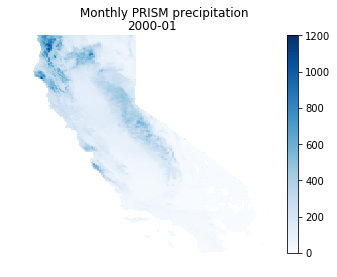

In [104]:
prism = pris.copy()

# create a ScalarMappable, initialize a data structure, fake the array of the scalar mappable, set max to 99th percentile of data
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=0, vmax=1200))#vmax=np.percentile(final, 99)))
sm._A = []


s = np.shape(prism)
nFrames = 12*16 # 12 months * 16 years
A = np.zeros((prism.shape[0], prism.shape[1], nFrames))

# Make the dates to be annotated
dates = []

mons = range(1,13)
yrs = range(2000,2016)

for y in yrs:
    for m in mons:
        dates.append(datetime.date(y,m,1))  #year, month, day

fig = plt.figure()
supt = plt.suptitle("Monthly PRISM precipitation")
title = plt.title(str(dates[0])[:-3])
ax = plt.axis('off')
cbar = plt.colorbar(sm)
im = plt.imshow(pris[:,:,0], interpolation="none", cmap="Blues")

def update(t):
    im.set_array(pris[:,:,t])
    title.set_text(str(dates[t])[:-3])

ani = matplotlib.animation.FuncAnimation(fig, func=update, frames=nFrames, 
                       repeat=True)
plt.show()

In [105]:
from IPython.display import HTML
HTML(ani.to_html5_video())

![title](prism.gif)

Now you have the monthly sums in a 3d array

# Visualize the monthly sums

NameError: name 'dfs' is not defined

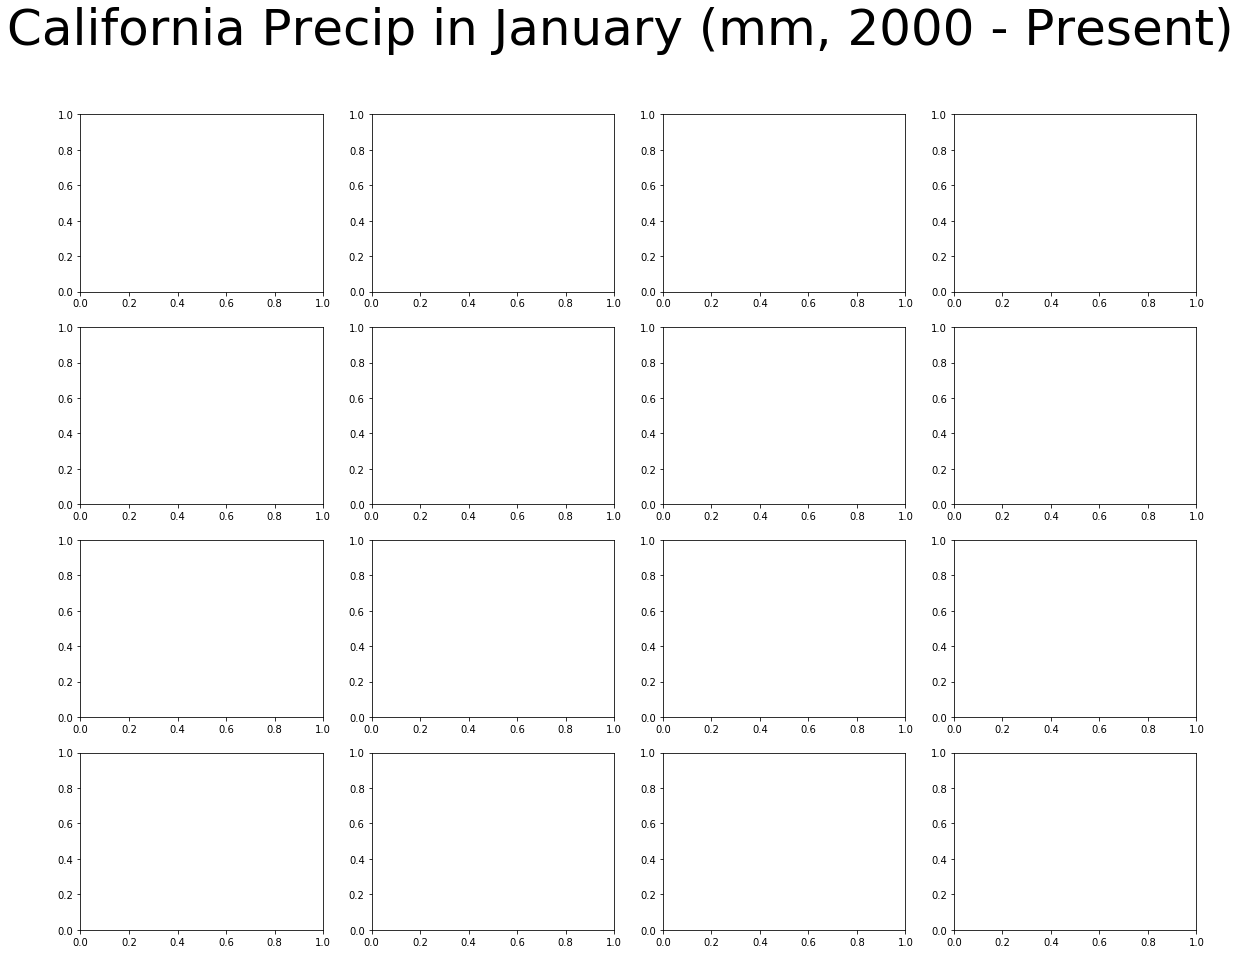

In [39]:
fig, axs = plt.subplots(4,4, figsize=(20,15))
axs = axs.ravel()

plt.suptitle('California Precip in January (mm, 2000 - Present)', size = 50)

for i in range(len(dfs)):
    
    a = axs[i].scatter(dfs[i]['longitude'],dfs[i]['latitude'],marker = "s",c = dfs[i]['ppt'],s= 20, lw = 0)
    axs[i].set_title(2000+i)
    axs[i].axis('off')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(a, cax=cbar_ax)

plt.show()

# Write to csv

In [ ]:
dfs_by_year = dict(zip(years,dfs))
for k,v in dfs_by_year.items():
    path = os.path.join(os.getcwd(), "trmm_csvs")
    v.to_csv(os.path.join(path,str(k)+"_.csv"))